WNixalo | 20181125

---

This notebook is an attempt to breach a score of 0.93 on the private leaderboard with ResNet34, using aggressive learning rates and extra progressive resizing. 2 versions of a model are trained, one with an extra cycle.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from fastai import *
from fastai.vision import *
__version__ # fastai

'1.0.28'

## Data

In [11]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True); #path

In [12]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [13]:
np.random.seed(5)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))
data = (src.transform(tfms, size=64)
       .databunch()
       .normalize(imagenet_stats))

In [14]:
arch = models.resnet34
acc_025 = partial(accuracy_thresh, thresh=0.25)
f_score = partial(fbeta, thresh=0.25)
learn   = create_cnn(data, arch, metrics=[acc_025, f_score])

In [7]:
learn.data.c2i

{'slash_burn': 0,
 'partly_cloudy': 1,
 'bare_ground': 2,
 'primary': 3,
 'selective_logging': 4,
 'conventional_mine': 5,
 'water': 6,
 'agriculture': 7,
 'road': 8,
 'haze': 9,
 'cloudy': 10,
 'cultivation': 11,
 'blooming': 12,
 'blow_down': 13,
 'clear': 14,
 'habitation': 15,
 'artisinal_mine': 16}

In [14]:
learn.data.c2i

{'conventional_mine': 0,
 'partly_cloudy': 1,
 'haze': 2,
 'water': 3,
 'habitation': 4,
 'bare_ground': 5,
 'road': 6,
 'cultivation': 7,
 'selective_logging': 8,
 'cloudy': 9,
 'blooming': 10,
 'agriculture': 11,
 'blow_down': 12,
 'primary': 13,
 'clear': 14,
 'artisinal_mine': 15,
 'slash_burn': 16}

## Training

### size 64 stage 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


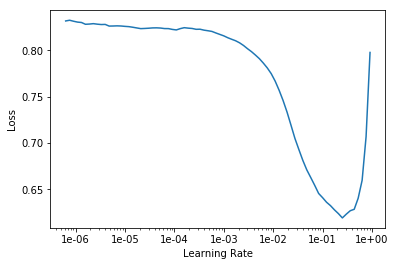

In [7]:
learn.lr_find(); learn.recorder.plot()

In [8]:
lr = 1e-2

In [9]:
learn.fit_one_cycle(6, slice(lr)) # oh cool: fastai by default uses slice(None, 0.003, None) for max_lr

Total time: 02:56
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.130109    0.116243    0.947077         0.895581  (00:29)
2      0.122847    0.111424    0.952018         0.897605  (00:30)
3      0.116664    0.107203    0.945369         0.905908  (00:29)
4      0.108828    0.102146    0.957578         0.907956  (00:29)
5      0.103934    0.096580    0.956764         0.914618  (00:29)
6      0.102207    0.095439    0.956655         0.916486  (00:29)



### size 64 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


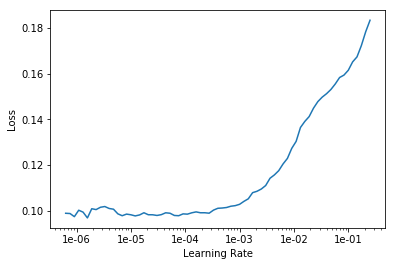

In [10]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [11]:
# new d-lr:
learn.lr_range(slice(lr/9, lr))

array([0.001111, 0.003333, 0.01    ])

In [12]:
learn.fit_one_cycle(6, slice(lr/9, lr)) 

Total time: 04:08
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.118918    0.117525    0.949802         0.895522  (00:41)
2      0.125757    0.118444    0.945871         0.896700  (00:41)
3      0.120044    0.113653    0.952701         0.897579  (00:41)
4      0.110139    0.103278    0.953472         0.911948  (00:42)
5      0.101447    0.095060    0.955630         0.918170  (00:41)
6      0.094236    0.092646    0.957541         0.920012  (00:41)



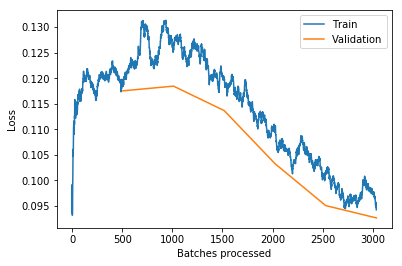

In [13]:
learn.recorder.plot_losses()

### size 128 stage 1

In [17]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


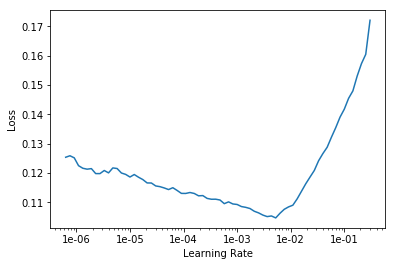

In [15]:
learn.lr_find(); learn.recorder.plot()

In [17]:
lr

0.01

In [18]:
learn.fit_one_cycle(6, slice(lr))

Total time: 07:57
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.106404    0.143273    0.939650         0.853916  (01:19)
2      0.119634    0.116367    0.952462         0.892107  (01:19)
3      0.113930    0.122871    0.952578         0.904147  (01:19)
4      0.102845    0.097620    0.953987         0.913758  (01:19)
5      0.093838    0.090206    0.961109         0.920778  (01:19)
6      0.091415    0.087299    0.960251         0.924442  (01:19)



In [19]:
learn.save('planet-rn34-sz128-stg1-aggr-rsz64')

### size 128 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


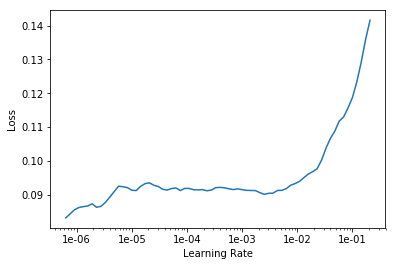

In [20]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [21]:
# new d-lr:
learn.lr_range(slice(lr/2/9, lr/2)) # lrs: lr/18, lr/6, lr/2; 5.5e-4, 1.6e-3, 5e-3

array([0.000556, 0.001667, 0.005   ])

In [22]:
learn.fit_one_cycle(6, slice(lr/2/9, lr/2)) 

Total time: 07:56
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.093793    0.089140    0.959517         0.921136  (01:18)
2      0.096755    0.090300    0.960070         0.920496  (01:19)
3      0.090770    0.090481    0.960695         0.923051  (01:19)
4      0.090148    0.087450    0.961756         0.922565  (01:19)
5      0.089314    0.085745    0.962417         0.925336  (01:19)
6      0.087949    0.084917    0.962366         0.926581  (01:19)



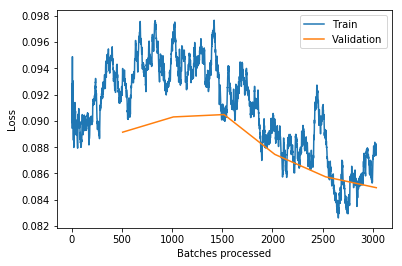

In [23]:
learn.recorder.plot_losses()

In [24]:
learn.save('planet-rn34-sz128-stg2-aggr-rsz64')

### size 256 stage 1

In [25]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


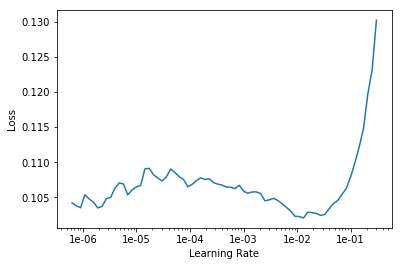

In [26]:
learn.freeze()
learn.lr_find(); learn.recorder.plot()

In [27]:
# lr = 5e-3 # 1e-2/2
lr = 1e-2/2

In [28]:
learn.fit_one_cycle(6, slice(lr))

Total time: 18:09
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.095412    0.089032    0.958195         0.923063  (03:00)
2      0.093080    0.099791    0.962889         0.919962  (03:02)
3      0.092367    0.087658    0.960579         0.922884  (03:01)
4      0.088490    0.085579    0.961123         0.924880  (03:01)
5      0.087679    0.084932    0.961218         0.925247  (03:01)
6      0.087334    0.084348    0.961581         0.926157  (03:02)



In [29]:
learn.save('planet-rn34-sz256-stg1-aggr-rsz64')

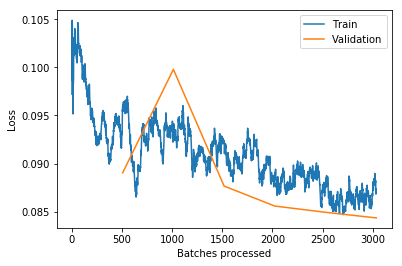

In [30]:
learn.recorder.plot_losses()

### size 256 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


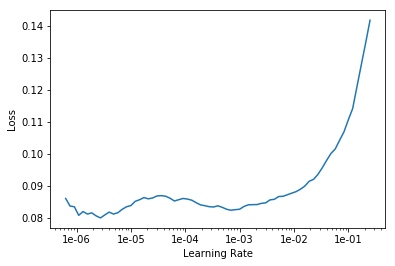

In [31]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [32]:
lr = 1e-3

In [33]:
learn.fit_one_cycle(6, slice(5e-5, lr))

Total time: 25:09
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.086774    0.084588    0.961697         0.926462  (04:06)
2      0.088873    0.084505    0.962054         0.925885  (04:15)
3      0.087274    0.084064    0.962359         0.926228  (04:19)
4      0.085111    0.084134    0.961632         0.926250  (04:12)
5      0.082155    0.084033    0.962678         0.925518  (04:06)
6      0.084214    0.083414    0.962155         0.926980  (04:07)



In [34]:
learn.save('planet-rn34-sz256-stg2-aggr-rsz64')

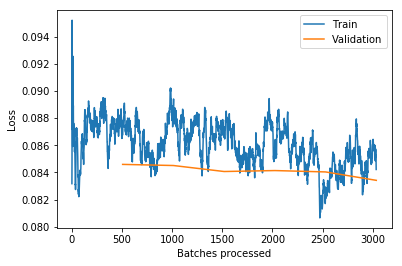

In [35]:
learn.recorder.plot_losses()

extra training

In [ ]:
# learn.load('planet-rn34-sz256-stg2-aggr-rsz64'); learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


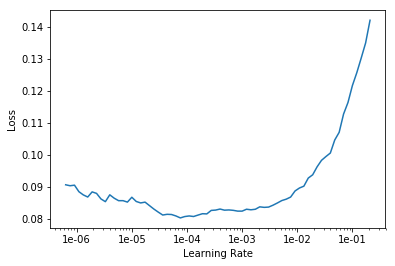

In [49]:
learn.lr_find(); learn.recorder.plot()

In [50]:
learn.fit_one_cycle(6, slice(5e-5/2, lr/2))

Total time: 24:49
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.083140    0.083376    0.961465         0.926513  (04:04)
2      0.084222    0.083345    0.962112         0.926514  (04:07)
3      0.085133    0.083491    0.962155         0.925630  (04:06)
4      0.086156    0.083241    0.961748         0.926588  (04:07)
5      0.085662    0.082943    0.962235         0.927568  (04:07)
6      0.083263    0.083046    0.961545         0.926912  (04:17)



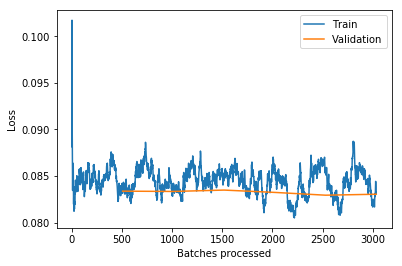

In [51]:
learn.recorder.plot_losses()

In [52]:
learn.save('planet-rn34-sz256-stg2-aggr-x-rsz64')

In [16]:
learn.load('planet-rn34-sz256-stg2-aggr-x-rsz64');
learn.data.c2i

{'conventional_mine': 0,
 'partly_cloudy': 1,
 'haze': 2,
 'water': 3,
 'habitation': 4,
 'bare_ground': 5,
 'road': 6,
 'cultivation': 7,
 'selective_logging': 8,
 'cloudy': 9,
 'blooming': 10,
 'agriculture': 11,
 'blow_down': 12,
 'primary': 13,
 'clear': 14,
 'artisinal_mine': 15,
 'slash_burn': 16}

## Predictions

In [7]:
subm_df = pd.read_csv(path/'sample_submission_v2.csv')
subdic = {c1:c2 for c1,c2 in zip(subm_df.image_name,subm_df.tags)}

In [8]:
def set_test_datafolder(learner, test_folder):
    learner.data = (src.add_test_folder(test_folder)
                    .transform(tfms, size=256)
                    .databunch().normalize(imagenet_stats))

1st testset portion

In [9]:
set_test_datafolder(learn, 'test-jpg')
fnames = [f.name.split('.')[0] for f in learn.data.test_ds.x.items]

In [56]:
preds1 = learn.TTA(ds_type=DatasetType.Test)

Total time: 12:14



2nd testset portion

In [10]:
set_test_datafolder(learn, 'test-jpg-additional')
fnames.extend([f.name.split('.')[0] for f in learn.data.test_ds.x.items])

In [58]:
preds2 = learn.TTA(ds_type=DatasetType.Test)

Total time: 06:25



In [59]:
preds = (torch.cat((preds1[0],preds2[0])), torch.cat((preds1[1],preds2[1])))

saving results to disk

In [11]:
# torch.save(preds, f'planet-rn34-sz256-stg2-aggr-rsz64.pkl')
preds = torch.load(f'planet-rn34-sz256-stg2-aggr-rsz64.pkl')

In [18]:
# torch.save(preds, f'planet-rn34-sz256-stg2-aggr-x-rsz64.pkl')
preds = torch.load(f'planet-rn34-sz256-stg2-aggr-x-rsz64.pkl')

## Submissions

In [12]:
import datetime
date = str(datetime.date.today()).replace('-','')

In [7]:
{v:k for k,v in learn.data.c2i.items()}

{0: 'blow_down',
 1: 'water',
 2: 'haze',
 3: 'blooming',
 4: 'bare_ground',
 5: 'slash_burn',
 6: 'agriculture',
 7: 'partly_cloudy',
 8: 'road',
 9: 'cultivation',
 10: 'cloudy',
 11: 'habitation',
 12: 'conventional_mine',
 13: 'primary',
 14: 'clear',
 15: 'artisinal_mine',
 16: 'selective_logging'}

In [19]:
idx2class = {v:k for k,v in learn.data.c2i.items()}

In [20]:
idx2class

{0: 'cultivation',
 1: 'selective_logging',
 2: 'blooming',
 3: 'clear',
 4: 'haze',
 5: 'conventional_mine',
 6: 'bare_ground',
 7: 'blow_down',
 8: 'partly_cloudy',
 9: 'road',
 10: 'water',
 11: 'agriculture',
 12: 'cloudy',
 13: 'artisinal_mine',
 14: 'habitation',
 15: 'slash_burn',
 16: 'primary'}

In [14]:
th = 0.15

for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[0][i]>=th)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

In [15]:
sub_msg = f"fastai {__version__}; rn34 2-stg; aggr-rsz64; thresh:{th}; {date}"

In [16]:
sub_name = f'planet-rn34-sz256-stg2-aggr-rsz64{date}_th{str(th).replace(".","")}.csv'
subm_df.to_csv(path/'submissions/'/sub_name, index=False, )
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submissions/{sub_name} -m "{sub_msg}"

100%|██████████████████████████████████████| 3.21M/3.21M [00:00<00:00, 3.96MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

## Results

threshold | aggr-64 | aggrx64
--------  | ------- | -------
0.350     | ------- | -------
0.300     | ------- | -------
0.250     | ------- | -------
0.200     | ------- | -------
0.150     | 0.89321 | -------

### previous results

training for 1 6-length cycle for each stage with 2 sizes (20% val out):

    thres    aggr1  -  aggr2  -  aggr2x
    0.400 - ------- - 0.90992 - -------
    0.350 - ------- - 0.91524 - 0.91519
    0.300 - 0.91920 - 0.91341 - 0.91417
    0.275 - ------- - ------- - -------
    0.250 - 0.92314 - 0.88908 - 0.89742
    0.225 - ------- - ------- - -------
    0.200 - 0.92532 - 0.88367 - 0.88705
    0.180 - 0.92532 - ------- - -------
    0.150 - 0.92428 - ------- - -------

All results @80% train:

threshold| norm1   |  aggr1  |  aggr1x |  aggr2  |  aggr2x
 ------- | ------- | ------- | ------- | ------- | ------- 
   0.400 | ------- | ------- | ------- | 0.90992 | -------
   0.350 | ------- | ------- | 0.91230 | 0.91524 | 0.91519
   0.300 | 0.92206 | 0.91920 | 0.91757 | 0.91341 | 0.91417
   0.250 | 0.92546 | 0.92314 | 0.92074 | 0.88908 | 0.89742
   0.200 | 0.92601 | 0.92532 | 0.92278 | 0.88367 | 0.88705
   0.180 | ------- | 0.92532 | ------- | ------- | -------
   0.150 | 0.92329 | 0.92428 | 0.92210 | 0.92329 | ------- 

Results:

threshold | normal-pvt-score | aggr-1-pvt-score
-|-|-
0.3|0.92206|0.91920
0.25|0.92546|0.92314
0.2|0.92601|0.92532
0.15|0.92329|0.92428

Final metrics:

model|train_loss | valid_loss | accuracy_thresh | fbeta
-|-|-|-|-
norm-1|0.076459  |  0.080886  |  0.964379    |     0.929328
aggr-1|0.086619  |  0.087704  |  0.961886    |     0.926379

Training schedule:

stage|norm-1 6len-cycle dlr|aggr-1 6len-cycle dlr
-|-|-
size128-1|0.01|0.01
size128-2|1e-5, 1.414214e-4, 0.002|5.56e-4, 0.001667, 0.005 
size256-1|0.005|0.01
size256-2|1e-5, 4.472136e-5, 2e-4|1.11e-4, 3.33e-4, 0.001

In [ ]:
learn.lr_range(slice(1e-5, 1e-2/5))

################################################################################

#### training schedule (text)

---

Model training schedules:
norm-1:

size128 stg1:

    # 1 6-len cycle:
    lr = 1e-2
    learn.lr_range(slice(lr)) = array([0.003333, 0.003333, 0.01    ])
    # frozen: only 0.01 for last layer-group used
    
size128 stg2:

    # 1 6-len cycle:
    learn.lr_range(slice(1e-5,lr/5)) = aarray([1.000000e-05, 1.414214e-04, 2.000000e-03])
    
size256 stg1:

    # 1 6-len cycle:
    lr = 5e-3
    learn.lr_range(slice(lr)) = array([3.333333e-06, 3.333333e-06, 1.000000e-05])
    # frozen: only 1e-5 for last layer-group used
    
size256 stg2:

    # 1 6-len cycle:
    lr = 1e-3
    learn.lr_range(slice(1e-5, lr/5)) = array([1.000000e-05, 4.472136e-05, 2.000000e-04])
    
aggr-1:

size128 stg1:

    # 1 6-len cycle:
    lr = 1e-2
    learn.lr_range(slice(lr)) = array([0.003333, 0.003333, 0.01    ])
    # frozen: only 0.01 for last layer-group used
    
size128 stg2:

    # 1 6-len cycle:
    learn.lr_range(slice(lr/2/9,lr/2)) = array([0.000556, 0.001667, 0.005   ])
    
size256 stg1:

    # 1 6-len cycle:
    lr = 1e-2
    learn.lr_range(slice(lr)) = array([0.003333, 0.003333, 0.01    ])
    # frozen: only 1e-5 for last layer-group used
    
size256 stg2:

    # 1 6-len cycle:
    lr = 1e-3
    learn.lr_range(slice(lr/9, lr)) = array([0.000111, 0.000333, 0.001   ])
    

### discovering the class mappings problem:

In [7]:
{v:k for k,v in learn.data.c2i.items()}

{0: 'blow_down',
 1: 'water',
 2: 'haze',
 3: 'blooming',
 4: 'bare_ground',
 5: 'slash_burn',
 6: 'agriculture',
 7: 'partly_cloudy',
 8: 'road',
 9: 'cultivation',
 10: 'cloudy',
 11: 'habitation',
 12: 'conventional_mine',
 13: 'primary',
 14: 'clear',
 15: 'artisinal_mine',
 16: 'selective_logging'}

In [19]:
idx2class = {v:k for k,v in learn.data.c2i.items()}

In [20]:
idx2class

{0: 'cultivation',
 1: 'selective_logging',
 2: 'blooming',
 3: 'clear',
 4: 'haze',
 5: 'conventional_mine',
 6: 'bare_ground',
 7: 'blow_down',
 8: 'partly_cloudy',
 9: 'road',
 10: 'water',
 11: 'agriculture',
 12: 'cloudy',
 13: 'artisinal_mine',
 14: 'habitation',
 15: 'slash_burn',
 16: 'primary'}

### recreating the class mappings problem:

In [7]:
# initialize a fresh learner and data
learn.data.c2i

{'artisinal_mine': 0,
 'slash_burn': 1,
 'road': 2,
 'haze': 3,
 'cultivation': 4,
 'blow_down': 5,
 'conventional_mine': 6,
 'water': 7,
 'blooming': 8,
 'clear': 9,
 'primary': 10,
 'agriculture': 11,
 'cloudy': 12,
 'partly_cloudy': 13,
 'bare_ground': 14,
 'habitation': 15,
 'selective_logging': 16}

In [9]:
# same kernel. load weights
learn.load('planet-rn34-sz256-stg2-aggr-x-rsz64')
learn.data.c2i

{'artisinal_mine': 0,
 'slash_burn': 1,
 'road': 2,
 'haze': 3,
 'cultivation': 4,
 'blow_down': 5,
 'conventional_mine': 6,
 'water': 7,
 'blooming': 8,
 'clear': 9,
 'primary': 10,
 'agriculture': 11,
 'cloudy': 12,
 'partly_cloudy': 13,
 'bare_ground': 14,
 'habitation': 15,
 'selective_logging': 16}

In [14]:
# adjust data size
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn.data = data
learn.data.c2i

{'artisinal_mine': 0,
 'slash_burn': 1,
 'road': 2,
 'haze': 3,
 'cultivation': 4,
 'blow_down': 5,
 'conventional_mine': 6,
 'water': 7,
 'blooming': 8,
 'clear': 9,
 'primary': 10,
 'agriculture': 11,
 'cloudy': 12,
 'partly_cloudy': 13,
 'bare_ground': 14,
 'habitation': 15,
 'selective_logging': 16}

In [17]:
# add a test set
learn.data = (src.add_test_folder('test-jpg')
                .transform(tfms, size=256)
                .databunch().normalize(imagenet_stats))
learn.data.c2i

{'artisinal_mine': 0,
 'slash_burn': 1,
 'road': 2,
 'haze': 3,
 'cultivation': 4,
 'blow_down': 5,
 'conventional_mine': 6,
 'water': 7,
 'blooming': 8,
 'clear': 9,
 'primary': 10,
 'agriculture': 11,
 'cloudy': 12,
 'partly_cloudy': 13,
 'bare_ground': 14,
 'habitation': 15,
 'selective_logging': 16}

Loading weights from a previous model, changing data size / transforms, and adding test data *do not* change the class mapping of a learner: `learn.data.c2i`. This is despite it seeming to be the case to me when I discovered this problem (I may have just had a mappings dict printed from a previous session). Changing the random seed also has no effect.

In [8]:
# restart kernel. fresh data and learner; same random seed.
learn.data.c2i

{'slash_burn': 0,
 'partly_cloudy': 1,
 'bare_ground': 2,
 'primary': 3,
 'selective_logging': 4,
 'conventional_mine': 5,
 'water': 6,
 'agriculture': 7,
 'road': 8,
 'haze': 9,
 'cloudy': 10,
 'cultivation': 11,
 'blooming': 12,
 'blow_down': 13,
 'clear': 14,
 'habitation': 15,
 'artisinal_mine': 16}

Restarting the kernel *does change the class mapping* of `learn.data.c2i`.

In [15]:
# re-importing fastai library and then re-initializing data and learner:
learn.data.c2i

{'slash_burn': 0,
 'partly_cloudy': 1,
 'bare_ground': 2,
 'primary': 3,
 'selective_logging': 4,
 'conventional_mine': 5,
 'water': 6,
 'agriculture': 7,
 'road': 8,
 'haze': 9,
 'cloudy': 10,
 'cultivation': 11,
 'blooming': 12,
 'blow_down': 13,
 'clear': 14,
 'habitation': 15,
 'artisinal_mine': 16}

In [19]:
np.math.factorial(17)

355687428096000

In [27]:
params = list(learn.model.parameters())

In [32]:
x = params[0]

In [34]:
x.flatten().shape

torch.Size([9408])

In [52]:
params = list(learn.model.parameters())
total_parameters = [len(param.flatten()) for param in params]
sum(total_parameters)

21821265

In [28]:
for p in params: print(len(p))b

64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
1024
1024
512
512
512
512
17
17


In [23]:
?learn.model.parameters

Signature: learn.model.parameters(recurse=True)
Docstring:
Returns an iterator over module parameters.

This is typically passed to an optimizer.

Args:
    recurse (bool): if True, then yields parameters of this module
        and all submodules. Otherwise, yields only parameters that
        are direct members of this module.

Yields:
    Parameter: module parameter

Example::

    >>> for param in model.parameters():
    >>>     print(type(param.data), param.size())
    <class 'torch.FloatTensor'> (20L,)
    <class 'torch.FloatTensor'> (20L, 1L, 5L, 5L)
File:      /opt/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py
Type:      method


In [22]:
len(learn.model.parameters)

TypeError: object of type 'method' has no len()

## end